#### ¿No has tenido bastante?

Prueba a controlar el flappy bird https://github.com/markub3327/flappy-bird-gymnasium

pip install flappy-bird-gymnasium

import flappy_bird_gymnasium  
env = gym.make("FlappyBird-v0")

Estado (12 variables):
  * the last pipe's horizontal position
  * the last top pipe's vertical position
  * the last bottom pipe's vertical position
  * the next pipe's horizontal position
  * the next top pipe's vertical position
  * he next bottom pipe's vertical position
  * the next next pipe's horizontal position
  * the next next top pipe's vertical position
  * the next next bottom pipe's vertical position
  * player's vertical position
  * player's vertical velocity
  * player's rotation

  Acciones:
  * 0 -> no hacer nada
  * 1 -> volar

In [6]:
%pip install flappy-bird-gymnasium -q
%pip install loky -q

In [7]:
import gymnasium as gym
import flappy_bird_gymnasium
from gymnasium.wrappers import RecordVideo
import numpy as np
import pygame
import gymnasium.utils.play
from MLP import MLP
import copy
from loky import get_reusable_executor
import random
import matplotlib.pyplot as plt

## AutoPlay - humano 🕹️

In [8]:
# # prueba lunar lander por humano
# env_human = gym.make("FlappyBird-v0", render_mode="rgb_array")

# flappy_bird_keys = {
#     (pygame.K_UP,): 1
# }
# gymnasium.utils.play.play(env_human, zoom=1, keys_to_action=flappy_bird_keys, noop=0)

## Desarrollo de funciones 🧩

### Modelo 🧠

In [9]:
# construir modelo
LAYERS = [12, 8, 4, 2]
model =  MLP(LAYERS)

### Política 🎯

In [10]:
def policy(observation, epsilon=0.1):
    # observation = np.array(observation).reshape(1, -1)  # Convertir a (1,8)
    if np.random.rand() < epsilon:  # 10% de las veces toma una acción aleatoria
        return np.random.randint(2)
    return np.argmax(model.forward(observation))  # 90% de las veces usa el modelo individuo MLP

### Entorno de exploración y función de ejecución 🌍

In [11]:
env = gym.make("FlappyBird-v0", use_lidar=False)

def run ():
    """
    Esta función genera un escenario de juego y ejecuta la política definida en la función policy.
    Al acabar el juego (cuando se estrella o aterriza), devuelve la recompensa acumulada.
    """
    observation, info = env.reset() # se abre un escenario de juego
    racum = 0
    while True:
        action = policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        observation = np.array(observation).reshape(1, -1)
        racum += reward
        if terminated or truncated:
            return racum

### Funciones bioinspiradas 🧬

In [12]:
# Función fitness
def evaluate_fitness(ind, num_eval_games):
    """Calcula el fitness promediando la recompensa de varias partidas."""
    total_reward = 0
    model.from_chromosome(ind)
    for _ in range(num_eval_games):
        total_reward += run()  # Ejecuta el agente en el entorno
    return total_reward/num_eval_games

def parallel_evaluation(population, num_eval_games, fitness_func):
    """Evalúa en paralelo el fitness de la población usando loky."""
    with get_reusable_executor() as executor:
        fitness_scores = list(executor.map(fitness_func, population, [num_eval_games]* len(population)))
    return fitness_scores

def sort_pop(population, fitness_scores):
    """Ordena la población según el fitness obtenido."""
    sorted_pop = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
    return [indiv for indiv, _ in sorted_pop], [fit for _, fit in sorted_pop]

# Funciones de cruce
def pmx_crossover(parent1, parent2):
    """Cruce de mapeo parcial (PMX) entre dos cromosomas representados como listas de floats."""
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))

    child1, child2 = parent1.copy(), parent2.copy()

    mapping1 = {parent1[i]: parent2[i] for i in range(start, end)}
    mapping2 = {parent2[i]: parent1[i] for i in range(start, end)}

    def fill_child(child, parent, mapping):
        for i in range(size):
            if child[i] == -1.0:
                gene = parent[i]
                while gene in mapping:
                    gene = mapping[gene]
                child[i] = gene
        return child

    child1[start:end], child2[start:end] = parent1[start:end], parent2[start:end]
    child1, child2 = fill_child(child1, parent2, mapping1), fill_child(child2, parent1, mapping2)

    return child1, child2

def sbx_crossover(parent1, parent2, eta_c=15):
    """
    Simulated Binary Crossover (SBX) para variables continuas en [0,1].
    eta_c: distribution, controla la 'intensidad' del cruce.
    """

    # if np.random.rand() >= pc:
    #     return np.copy(parent1), np.copy(parent2)

    n_var = len(parent1)
    child1 = np.zeros(n_var)
    child2 = np.zeros(n_var)

    for i in range(n_var):
        x1 = parent1[i]
        x2 = parent2[i]

        if x1 > x2:
            x1, x2 = x2, x1

        if abs(x1 - x2) < 1e-14:
            # Si son prácticamente iguales, se copia
            child1[i] = x1
            child2[i] = x2
        else:
            # Beta determina el grado de cruce
            rand = np.random.rand()
            beta = 1.0 + (2.0 * (x1 - 0.0) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta_c + 1.0))
            if rand <= 1.0 / alpha:
                betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

            c1 = 0.5 * ((x1 + x2) - betaq * (x2 - x1))

            beta = 1.0 + (2.0 * (1.0 - x2) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta_c + 1.0))
            if rand <= 1.0 / alpha:
                betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

            c2 = 0.5 * ((x1 + x2) + betaq * (x2 - x1))

            c1 = min(max(c1, 0.0), 1.0)
            c2 = min(max(c2, 0.0), 1.0)

            # Aleatoriamente asignamos quién obtiene c1 y c2
            if np.random.rand() < 0.5:
                child1[i] = c2
                child2[i] = c1
            else:
                child1[i] = c1
                child2[i] = c2

    return child1, child2

def crossover(ind1, ind2, pcross):
    if random.random() > pcross:
        return ind1.copy(), ind2.copy()
    return sbx_crossover(ind1, ind2)

# Función selección
def select(population, T: int) -> list[list]:
    """Return a copy of an individual by tournament selection. Population already ordered by fitness"""
    choices=random.sample(copy.copy(population), k=T)
    indices=[population.index(c) for c in choices]
    return population[np.argmin(indices)]

# Función mutación
def mutate(ind, pmut):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.
    """
    def mutate_random(individual: list, pmut: float) -> list:
        """ Mutación aleatoria """
        if random.random() < pmut:
            index1, index2 = random.choices(range(len(individual)), k=2)
            individual[index1] = random.uniform(-1,1)
            individual[index2] = random.uniform(-1,1)
        return individual

    def mutate_gaussian(ind, pmut, sigma=0.1):
        """
        Mutación gaussiana: con probabilidad pmut, se le suma
        una perturbación normal(0, sigma).
        """
        for i in range(len(ind)):
            if np.random.rand() < pmut:
                # pequeña perturbación
                perturb = np.random.normal(0, sigma)
                ind[i] += perturb
                # recortamos a [0,1]
                ind[i] = np.clip(ind[i], 0, 1)
        return ind
    mutation_operator = np.random.choice([mutate_gaussian, mutate_random])
    return mutation_operator(ind, pmut)

# Función evolutiva
def evolve(population, fit_func, num_eval_games=3, pmut=0.2, pcross=0.8, ngen=3000, T=6, trace=50, elitism=False):
    best_fitness = []
    worst_fitness = []
    mean_fitness = []

    goat_fitness = -np.inf
    goat_ind = []
    for gen in range(ngen):

        # Evaluar fitness en paralelo
        fitness_scores = parallel_evaluation(population, num_eval_games, fit_func)
        # fitness_scores = [fit_func(ind, num_eval_games) for ind in population]

        # Ordenar por fitness
        sorted_population, sorted_scores = sort_pop(population, fitness_scores)

        # Guardar estadísticas
        best_fitness.append(sorted_scores[0])
        worst_fitness.append(sorted_scores[-1])
        mean_fitness.append(np.mean(sorted_scores))

        # Generar nueva población con cruce y mutación
        new_population = []
        if elitism:
            new_population.append(sorted_population[0].copy())
        while len(new_population) < len(population):
            parent1 = select(sorted_population, T)
            parent2 = select(sorted_population,T)
            childs = crossover(parent1, parent2, pcross=pcross)
            final_child1, final_child2 = mutate(childs[0], pmut=pmut), mutate(childs[1], pmut=pmut)

            # new_model1, new_model2 = MLP(LAYERS), MLP(LAYERS)
            # new_model1.from_chromosome(final_child1)
            # new_model2.from_chromosome(final_child2)

            new_population.append(final_child1 if type(final_child1) == list else final_child1.tolist())
            new_population.append(final_child2 if type(final_child2) == list else final_child2.tolist())


        population = [*new_population]

        # Guardar mejor individuo
        if sorted_scores[0] > goat_fitness:
            goat_fitness = sorted_scores[0]
            goat_ind = sorted_population[0].copy()

        if gen % trace == 0:
            print(f"Generation {gen} -> best fitness: {sorted_scores[0]}")
        # print(f"-> best fitness: {sorted_scores[0]}")
    print(f'Final best fitness: {sorted_scores[0]}')

    return population, goat_ind, best_fitness, worst_fitness, mean_fitness


## Neuroevolución 🔬🦾

In [13]:
POP_SIZE = 100
GENS = 8000
EVAL_GAMES = 3  # Número de partidas por individuo para calcular fitness

# Inicializar población aleatoria
population = np.random.uniform(-5, 5, size=(POP_SIZE, len(model.to_chromosome()))).tolist()

In [14]:
population, goat_ind, best_fitness, worst_fitness, mean_fitness = evolve(population,
                                                               evaluate_fitness,
                                                               num_eval_games=EVAL_GAMES,
                                                               ngen=GENS,
                                                               T=6,
                                                               trace=50,
                                                               elitism=False
                                                               )

Generation 0 -> best fitness: 4.933333333333329
Generation 50 -> best fitness: 5.066666666666663
Generation 100 -> best fitness: 5.699999999999993
Generation 150 -> best fitness: 5.66666666666666
Generation 200 -> best fitness: 5.499999999999994
Generation 250 -> best fitness: 6.266666666666659
Generation 300 -> best fitness: 4.766666666666663
Generation 350 -> best fitness: 5.633333333333327
Generation 400 -> best fitness: 6.233333333333326
Generation 450 -> best fitness: 5.399999999999994
Generation 500 -> best fitness: 6.199999999999993
Generation 550 -> best fitness: 6.899999999999991
Generation 600 -> best fitness: 6.099999999999993
Generation 650 -> best fitness: 5.4666666666666615
Generation 700 -> best fitness: 6.16666666666666
Generation 750 -> best fitness: 5.599999999999994
Generation 800 -> best fitness: 5.433333333333327
Generation 850 -> best fitness: 5.399999999999994
Generation 900 -> best fitness: 5.799999999999993
Generation 950 -> best fitness: 5.399999999999994
Gene

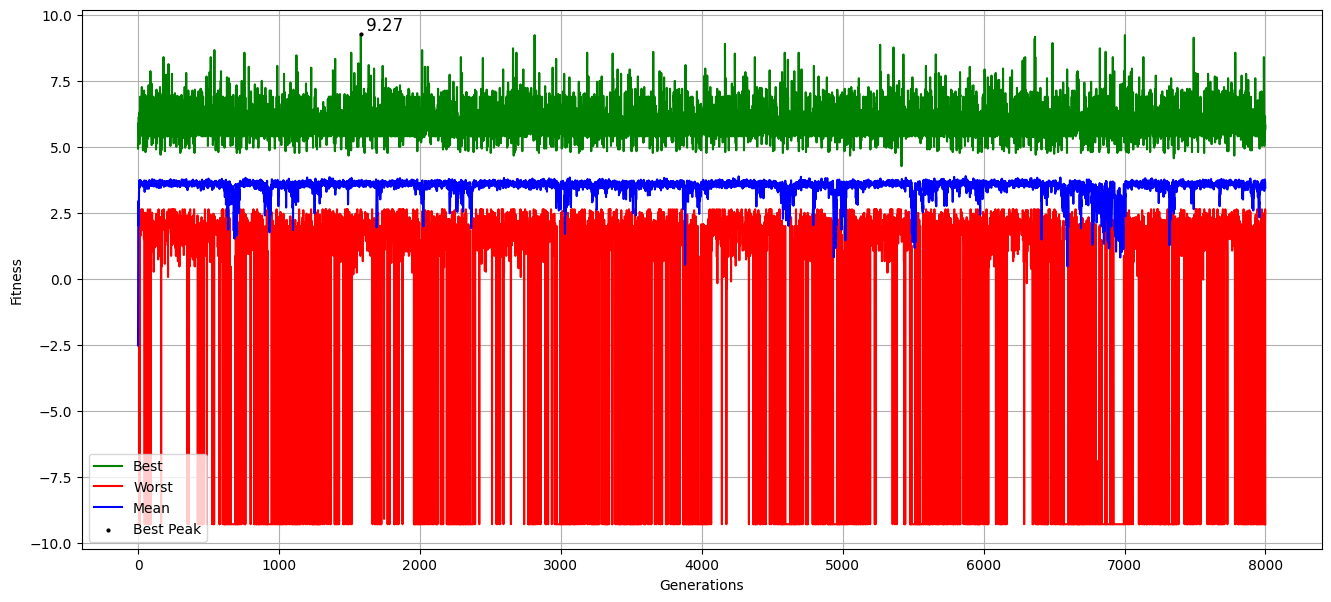

In [15]:
plt.figure(figsize=(16, 7))
plt.plot(best_fitness, color='green', label='Best')  # Línea verde
plt.plot(worst_fitness, color='red', label='Worst')  # Línea roja
plt.plot(mean_fitness, color='blue', label='Mean')  # Línea azul

# Encontrar el índice y el valor máximo de best_fitness
max_index = np.argmax(best_fitness)
max_value = best_fitness[max_index]

# Marcar el mejor fitness con un punto grande y una etiqueta
plt.scatter(max_index, max_value, color='black', s=4, zorder=3, label="Best Peak")
plt.text(max_index, max_value, f" {max_value:.2f}", fontsize=12, verticalalignment='bottom')

# Etiquetas y grid
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.grid()
plt.legend()
plt.show()

prueba del mejor individuo

In [16]:
env_test = gym.make("FlappyBird-v0", use_lidar=False, render_mode="human")
model_test = MLP(LAYERS)
# model_test.from_chromosome(population[0])
model_test.from_chromosome(goat_ind)

def policy_test(observation, epsilon=0.1):
    if np.random.rand() < epsilon:  # 10% de las veces toma una acción aleatoria
        return np.random.randint(4)
    return np.argmax(model_test.forward(observation))  # 90% de las veces usa el modelo individuo MLP

def run_test():
    """
    Esta función genera un escenario de juego y ejecuta la política definida en la función policy.
    Al acabar el juego (cuando se estrella o aterriza), devuelve la recompensa acumulada.
    """
    observation, info = env_test.reset() # se abre un escenario de juego
    racum = 0
    while True:
        action = policy_test(observation)
        observation, reward, terminated, truncated, info = env_test.step(action)
        racum += reward
        if terminated or truncated:
            return racum

for e in range(10):
    print(f"Reward {e+1}: {run_test()}")
env_test.close()

Reward 1: 3.8999999999999986
Reward 2: 2.0000000000000013
Reward 3: 2.0000000000000013
Reward 4: 3.8999999999999986
Reward 5: 2.0000000000000013
Reward 6: 3.3000000000000007
Reward 7: 2.0000000000000013
Reward 8: 3.9999999999999982
Reward 9: 4.1999999999999975
Reward 10: 3.8999999999999986


In [17]:
goat_ind

[0.7019876037099347,
 0.9754255307101808,
 0.34825210661389333,
 0.5744226593372188,
 0.9812171704933307,
 0.035333077529533886,
 0.3788554100982549,
 0.9142578098670526,
 0.009101958568627218,
 0.9416262713529184,
 0.010712117275456588,
 0.7209883877791716,
 0.9281453029529942,
 0.8940053824451418,
 0.9093729223252077,
 0.9333336387205263,
 0.6004761487620076,
 0.8365469289756683,
 0.7241942366514343,
 0.8262531371605367,
 0.6299856650513449,
 0.0015036267497703665,
 0.6451319481542531,
 0.9226239529974666,
 0.6222600801216103,
 0.13078141606699556,
 0.0,
 0.5290685397762647,
 0.7293421188613628,
 0.3563733081218911,
 0.07398995057352427,
 0.9819678646951532,
 0.0037037979178510994,
 0.39082369711813675,
 0.8492236605675505,
 0.7414866314866667,
 0.9997627224875645,
 0.45477670916860485,
 0.0830924237225722,
 0.11776864343627348,
 0.48036379467218127,
 0.07479496598474492,
 0.03250113976108259,
 0.3088399011815999,
 0.5880947482293157,
 0.8374987053988224,
 0.007263506703554967,
 0.91